In [1]:
# Load bible data and create a dataframe from the pkl
import pandas as pd
import numpy as np

In [2]:
df = pd.read_pickle('bible_df.pkl')
# Print out the column names
print(df.head())

   Unnamed: 0  Unnamed: 0.1  Verse ID Book Name  Book Number  Chapter  Verse  \
0           0             0         1   Genesis            1        1      1   
1           1             1         2   Genesis            1        1      2   
2           2             2         3   Genesis            1        1      3   
3           3             3         4   Genesis            1        1      4   
4           4             4         5   Genesis            1        1      5   

                                                Text  \
0  In the beginning God created the heavens and t...   
1  And the earth was waste and void; and darkness...   
2  And God said, Let there be light: and there wa...   
3  And God saw the light, that it was good: and G...   
4  And God called the light Day, and the darkness...   

                                           Embedding  
0  [0.029208950698375702, -0.012818936258554459, ...  
1  [-0.005489692557603121, -0.03504909574985504, ...  
2  [0.00895688030

In [3]:
# Load the bible into Chroma - use the default embeddings
import chromadb
from chromadb.config import Settings

# Create a client, and create a collection
collection_name = 'the_bible_demo'
persist_directory = 'chroma'

client = chromadb.Client(Settings(persist_directory=persist_directory, chroma_db_impl="duckdb+parquet"))
collection = client.create_collection(collection_name)

# Add the bible to the collection - Chroma will embed it for you

chapters = df['Chapter'].tolist()
books = df['Book Name'].tolist()
verses = df['Verse'].tolist()

collection.add(
    ids = [str(id) for id in df['Verse ID'].tolist()],
    embeddings=df['Embedding'].tolist(),
    documents=df['Text'].tolist(),
    metadatas=[{"chapter": chapter, "book": book, "verse": verse} for chapter, book, verse in zip(chapters, books, verses)]
)

client.persist()
del client

Running Chroma using direct local API.
No existing DB found in chroma, skipping load
No existing DB found in chroma, skipping load


/Users/antontroynikov/miniforge3/envs/hackathon_demo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Persisting DB to disk, putting it in the save folder chroma


In [4]:
items = collection.get()

embeddings = items['embeddings']
books = [metadata['book'] for metadata in items['metadatas']]

<AxesSubplot:>

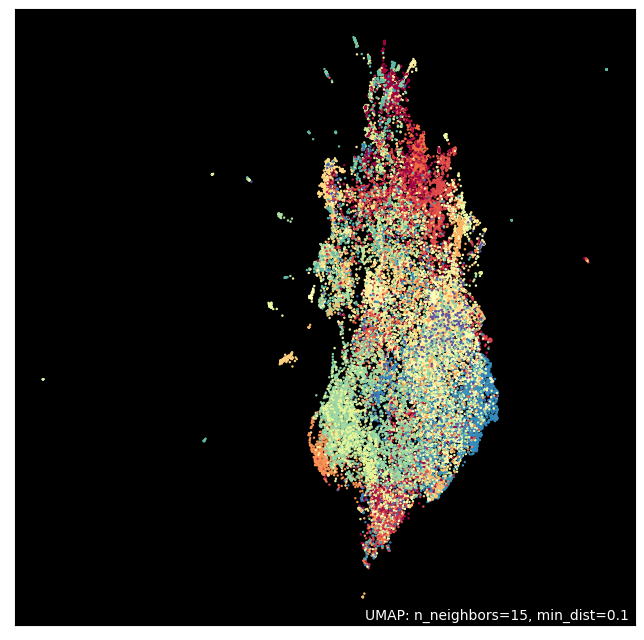

In [6]:
# Project the bible embeddings to 2D using UMAP
import umap
import umap.plot

mapper = umap.UMAP().fit(embeddings)

umap.plot.points(mapper, labels=np.array(books), background='black', show_legend=False)


In [8]:
# Let's ask God some questions
from langchain.vectorstores import Chroma
from langchain.chains import VectorDBQA
from langchain.embeddings import OpenAIEmbeddings
from langchain import OpenAI

collection_name = 'the_bible_demo'
persist_directory = 'chroma'

# Read in the oepnai api key from openai.key
openai_api_key = open('openai.key', 'r').read()

docsearch = Chroma(collection_name=collection_name, persist_directory=persist_directory, embedding_function=OpenAIEmbeddings(openai_api_key=openai_api_key))
chain = VectorDBQA.from_chain_type(OpenAI(temperature=0, openai_api_key=openai_api_key), chain_type="stuff", vectorstore=docsearch)

Running Chroma using direct local API.
loaded in 31102 embeddings
loaded in 1 collections
{'result': ' The greatest good is to love God with all your heart, soul, and mind.'}


In [19]:
print(chain({"query": "What is the gender of god?"}, return_only_outputs=True))

{'result': ' God is genderless.'}
